In [3]:
from controller.user_creation_controller import UserCreationController
PKL_PATH = r"..\data\temp_gui_controller.pkl"
DB_PATH = r"..\data\gui_database.db"
IMAGE_FOLDER = r"..\data/dataset-yalefaces"

# CREATE USER WORKFLOW

In [4]:
import os
import io
import base64
from PIL import Image
from werkzeug.datastructures import FileStorage

def import_subject_images(ids, image_folder="../../data/dataset-yalefaces"):
    sujet = f"subject0{ids}_"
    image_files = []
    for filename in os.listdir(image_folder):
        if filename.startswith(sujet):
            chemin_fichier = f"{image_folder}/{filename}"
            file = open(chemin_fichier, "rb")
            file_storage = FileStorage(stream=file, filename=filename)
            image_files.append(file_storage)
    return image_files

def display_images_side_by_side(images, background_color=(255, 255, 255)):
    images = [img.convert('RGB') for img in images]
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    new_im = Image.new('RGB', (total_width, max_height), background_color)
    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset, 0))
        x_offset += im.width
    display(new_im)

def base64_to_pil(b64_string):
    image_data = base64.b64decode(b64_string)
    image = Image.open(io.BytesIO(image_data))
    return image

import io
from PIL import Image
import numpy as np
from werkzeug.datastructures import FileStorage

def sanitize_filestorage_list(file_storage_list, output_format='JPEG'):
    """
    Transforme une liste de FileStorage en une nouvelle liste de FileStorage
    en coupant tout lien avec les fichiers sources (via conversion numpy -> FileStorage).
    """
    sanitized_list = []
    for i, fs in enumerate(file_storage_list):
        # Charger en tableau numpy
        image = Image.open(fs.stream).convert('RGB')  # .convert() pour garantir la compatibilité
        np_array = np.array(image)
        # Convertir numpy en FileStorage indépendant
        buffer = io.BytesIO()
        Image.fromarray(np_array).save(buffer, format=output_format)
        buffer.seek(0)
        new_fs = FileStorage(
            stream=buffer,
            filename=f"image_{i}.{output_format.lower()}",
            content_type=f"image/{output_format.lower()}"
        )
        sanitized_list.append(new_fs)
        fs.close()
    return sanitized_list

In [5]:
img_list = import_subject_images(1, IMAGE_FOLDER)
img_list = sanitize_filestorage_list(img_list)
img_size_value = (100, 100)
img_size_unit = "px"

response, code = UserCreationController.initialize_new_user(img_list, img_size_value, img_size_unit, PKL_PATH)
print(response, code)

2025-04-29 16:31:27,153 - INFO - Exécution du pré-traitement standard avec IMAGE_SIZE=(100, 100)...
2025-04-29 16:31:27,153 - INFO - Traitement de 11 fichiers FileStorage.


Initializing UserCreationController


Preprocessing (FileStorage List): 100%|██████████| 11/11 [00:00<00:00, 701.98it/s]
2025-04-29 16:31:27,169 - INFO - Pré-traitement terminé. 11 images traitées pour 1 sujets.


{} 200


2025-04-29 16:31:27,198 - INFO - Application de K-Same-Pixel avec k=4...
K-Same Pixel: 100%|██████████| 1/1 [00:00<00:00, 996.98it/s]
2025-04-29 16:31:27,201 - INFO - Traitement K-Same-Pixel terminé.


keys: ['images']


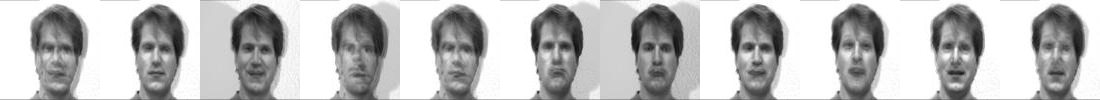

In [6]:
nb_same_pixel = 4
response, code = UserCreationController.apply_k_same_pixel(nb_same_pixel)

print(f"keys: {list(response.keys())}")
images = [base64_to_pil(img) for img in response['images']]
display_images_side_by_side(images)

n_components_optimal: 8
keys: ['images']


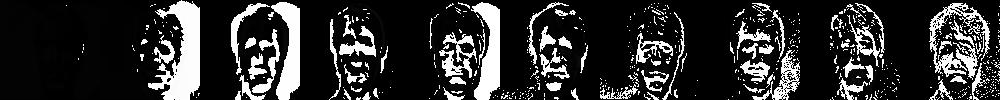

In [7]:
nb_components = 10
response, code = UserCreationController.generate_pca_components(nb_components)

print(f"keys: {list(response.keys())}")
images = [base64_to_pil(img) for img in response['images']]
display_images_side_by_side(images)

keys: ['images']


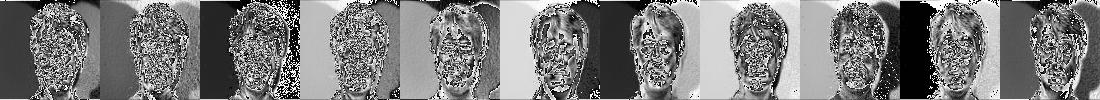

In [8]:
epsilon = 0.1
response, code = UserCreationController.apply_differential_privacy(epsilon)

print(f"keys: {list(response.keys())}")
images = [base64_to_pil(img) for img in response['images']]
display_images_side_by_side(images)

In [9]:
response, code = UserCreationController.save_user_in_db(DB_PATH)

print(f"keys: {list(response.keys())}")
print(f"user_id: {response['user_id']}")

keys: ['user_id']
user_id: 54
